# 基于pytorch和抱抱脸手🦌DDPM

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda:1'
print(f'Using device: {device}')

Using device: cuda:1


# 准备数据集
fashion-mnist

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 4, 8, 2, 4, 0, 8, 6])


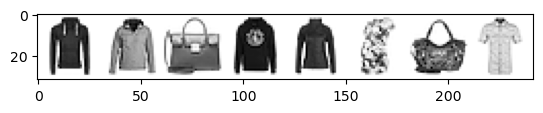

In [2]:

dataset = torchvision.datasets.FashionMNIST(root="famnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# 加噪方案
DDPM的加噪方案，这里不详细记录

因为fashion比较简单，所以前向后向过程就设置了40步

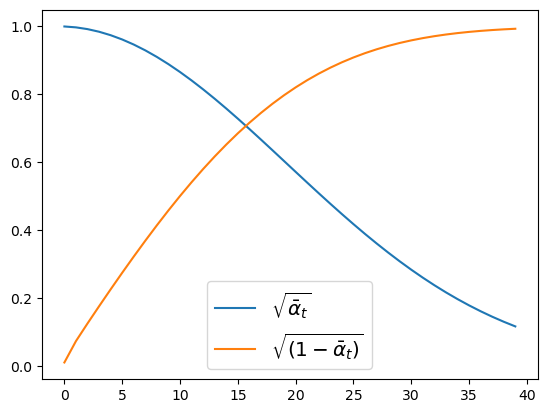

In [3]:
# 原始的alpha 与 beta
beta = torch.linspace(start=0.0001, end=0.2, steps=40).to(device)
alpha = 1-beta

# alpha前t向累乘
alpha_bar =  torch.cumprod(alpha, dim=0)

# 扩散过程中需要的两个量
alpha_bar_sqr = alpha_bar ** 0.5
alpha_bar_1_sqr = (1 - alpha_bar) ** 0.5

plt.plot(alpha_bar_sqr.cpu(), label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot(alpha_bar_1_sqr.cpu(), label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")


# x = torch.tensor([1,2,5])

# print(alpha[x])

In [4]:
# 给x0及时间t，返还x_t及噪声

def corrupt(x, timestep):
    x = x.to(device)
    timestep = timestep.to(device)
    # x是(n,c,h,w)
    # timestep是(n)，即为n个x每个分配一个噪声程度
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.randn_like(x).to(device)
    # alpha_t =   # (n)
    return x*alpha_bar_sqr[timestep].view(-1,1,1,1) + noise*alpha_bar_1_sqr[timestep].view(-1,1,1,1), noise

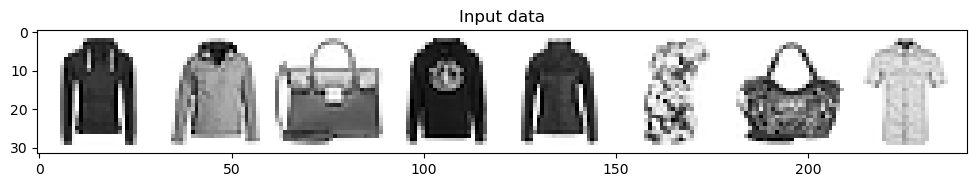

In [5]:
# 展示原图
fig, axs = plt.subplots(figsize=(12, 5))
axs.set_title('Input data')
axs.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

In [6]:
timestep = torch.randint(low=0, high=40, size=(8,)).to(device) # Left to right -> more corruption
print(timestep)

tensor([33, 13,  9,  7,  0, 22, 30, 24], device='cuda:1')


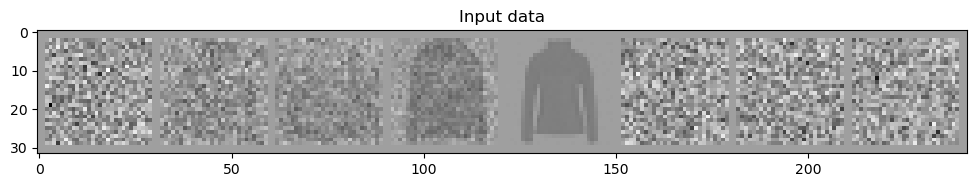

In [7]:
# 不同程度的加噪图片

noised_x, noise = corrupt(x, timestep)
fig, axs = plt.subplots(figsize=(12, 5))
axs.set_title('Input data')
axs.imshow(torchvision.utils.make_grid(noised_x.cpu())[0], cmap='Greys')

# 模型

In [8]:
# 从抱抱脸拿了一个Unet
# 输入是加噪图片(n,c,h,w)，及时间步长(n,)
# 输出是预测噪声(n,c,h,w)

from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=(28,28),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [9]:
# 参数量统计

sum([p.numel() for p in model.parameters()])

12980481

## 训练策略   
按照DDPM的算法

100%|██████████| 469/469 [01:06<00:00,  7.02it/s]


Finished epoch 0. Average loss for this epoch: 0.075855


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 1. Average loss for this epoch: 0.050310


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 2. Average loss for this epoch: 0.046301


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 3. Average loss for this epoch: 0.042907


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 4. Average loss for this epoch: 0.042475


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 5. Average loss for this epoch: 0.041039


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 6. Average loss for this epoch: 0.040680


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 7. Average loss for this epoch: 0.039577


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 8. Average loss for this epoch: 0.039566


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 9. Average loss for this epoch: 0.039490


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 10. Average loss for this epoch: 0.039463


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 11. Average loss for this epoch: 0.038906


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 12. Average loss for this epoch: 0.038359


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 13. Average loss for this epoch: 0.038726


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 14. Average loss for this epoch: 0.038113


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 15. Average loss for this epoch: 0.038382


100%|██████████| 469/469 [01:05<00:00,  7.15it/s]


Finished epoch 16. Average loss for this epoch: 0.038612


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 17. Average loss for this epoch: 0.037370


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]


Finished epoch 18. Average loss for this epoch: 0.037622


100%|██████████| 469/469 [01:05<00:00,  7.16it/s]

Finished epoch 19. Average loss for this epoch: 0.037712


(0.0, 0.1)

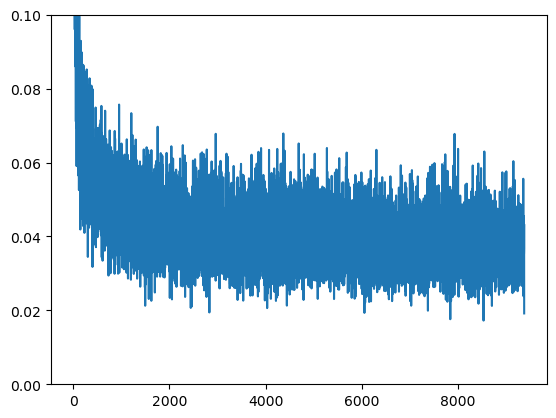

In [10]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 20

# Create the network
net = model
net.to(device)

net.eval()
# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

from tqdm import tqdm

# The training loop
for epoch in range(n_epochs):

    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        # rand是在0-1之间获取随机数，即获取n个随机加噪程度
        noise_amount = torch.randint(low=0, high=40, size=(x.shape[0],)).long().to(device)
        # 获取n个加噪后的图片
        noisy_x, noise = corrupt(x, noise_amount) # Create our noisy x

        # 模型去噪
        # print(noisy_x.shape)
        # print(noise_amount.shape)
        # 输入加噪图片与步长
        # 返回噪声预测
        pred = net(noisy_x.to(device), noise_amount, return_dict=False)[0]

        # 计算损失mse
        loss = loss_fn(pred, noise.to(device)) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

## 采样策略  
严格按照DDPM原文的sampling写的

/tmp/ipykernel_645823/1575386227.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)


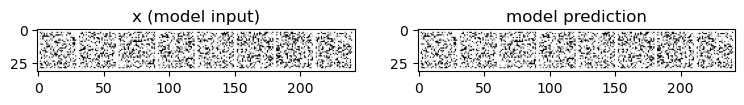

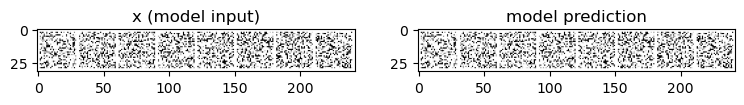

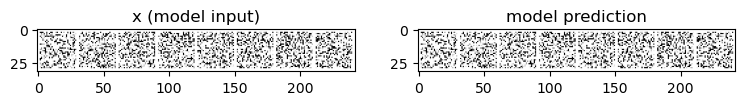

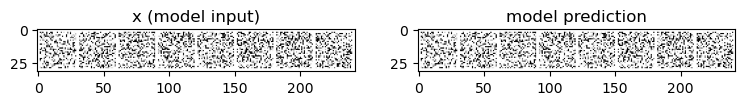

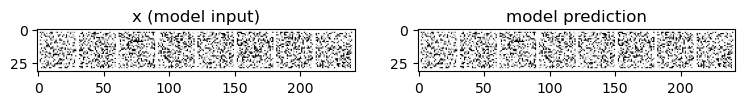

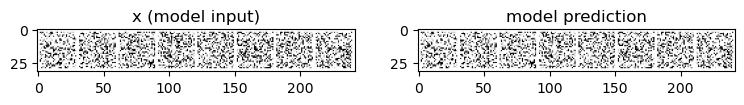

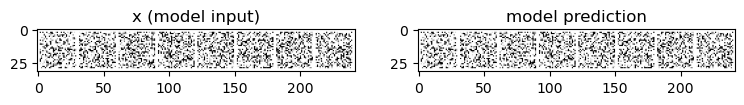

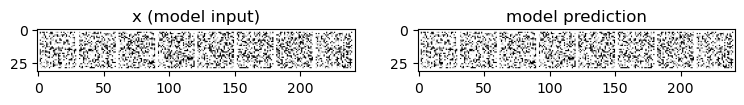

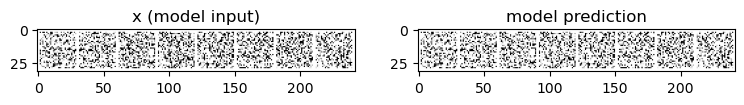

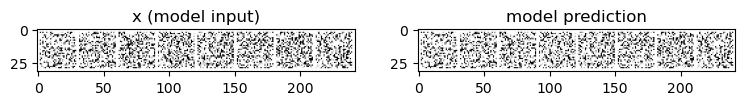

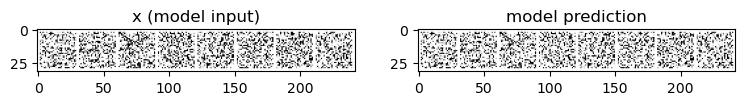

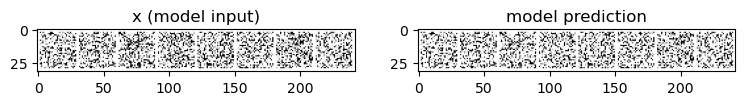

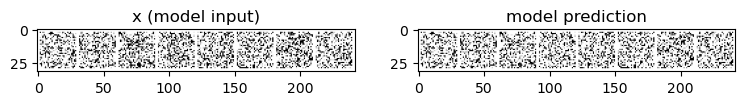

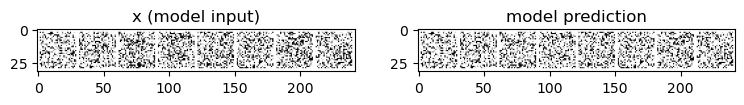

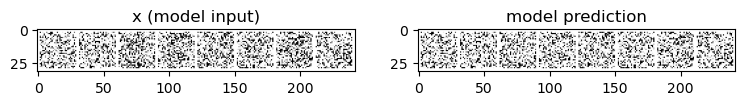

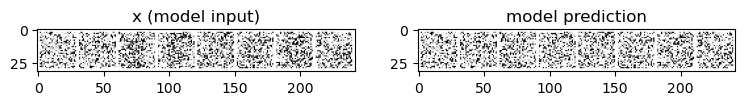

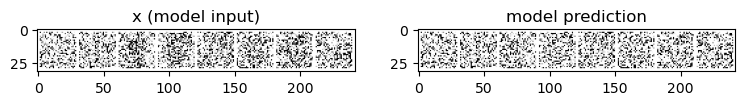

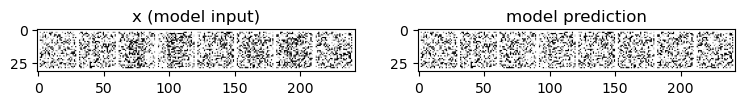

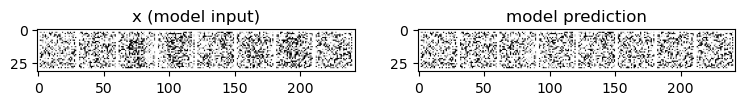

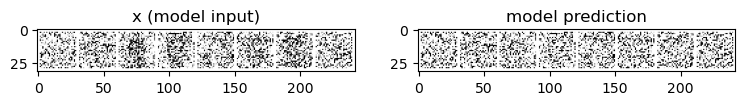

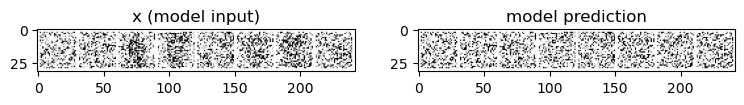

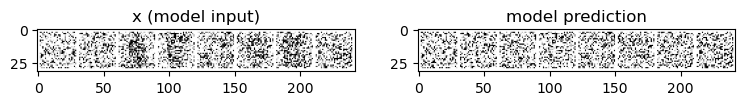

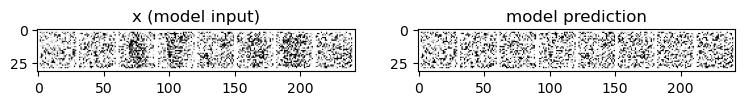

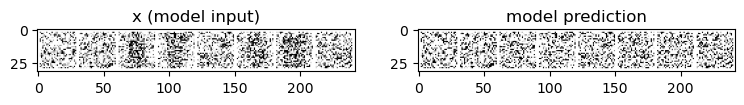

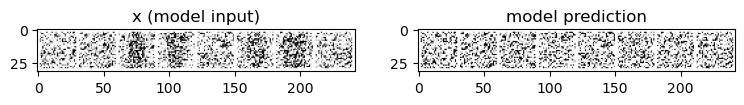

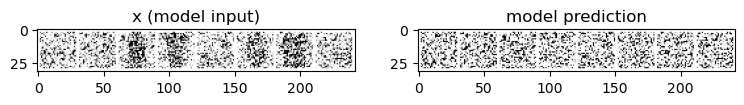

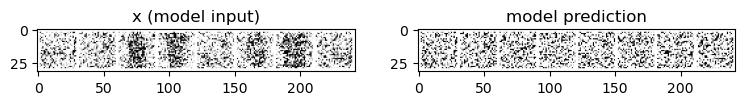

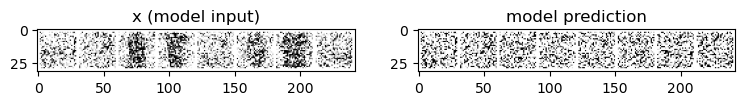

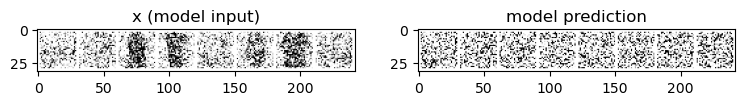

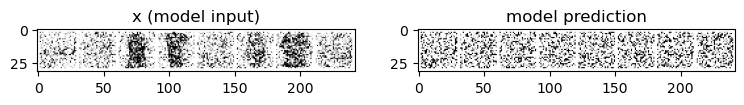

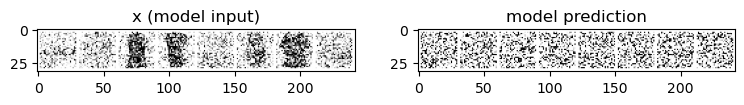

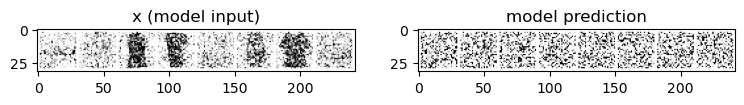

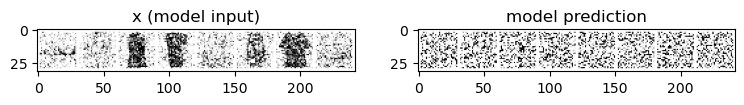

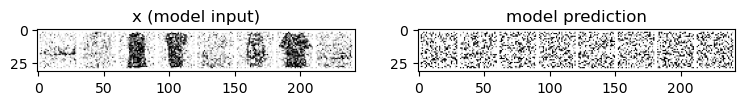

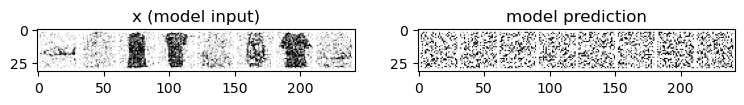

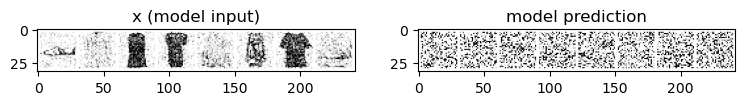

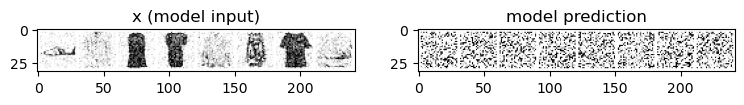

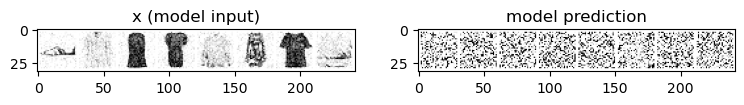

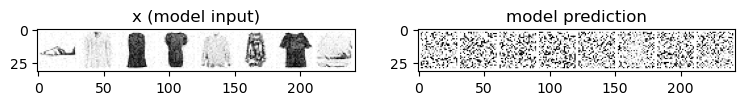

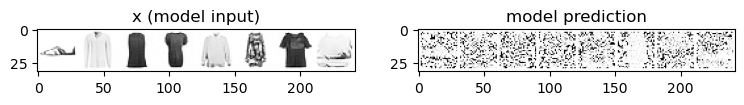

In [17]:
n_steps = 40  
x = torch.randn(8, 1, 28, 28).to(device) 
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps-1,-1,-1):  # 39————>0
    with torch.no_grad(): 
        timestep = torch.tensor([i]*x.shape[0]).long().to(device)
        pred = net(x, timestep, return_dict=False)[0]  # 预测噪声
        if i == 0:
            x = 1/(alpha[i]**0.5) * (x- (1-alpha[i])/(alpha_bar_1_sqr[i])*pred ) 
        else:
            x = 1/(alpha[i]**0.5) * (x- (1-alpha[i])/(alpha_bar_1_sqr[i])*pred ) + torch.sqrt((1-alpha[i]) * (1-alpha_bar[i-1]) / (1-alpha_bar[i])) * torch.randn_like(x)
        pred_output_history.append(pred.detach().cpu())
        step_history.append(x.detach().cpu()) # Store step for plotting


for i in range(n_steps):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
    axs[0].set_title('x (model input)')
    axs[1].set_title('model prediction')
    axs[0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

nb，入门diffusion